In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import xgboost as xgb
from xgboost import plot_importance
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

# Load Original Features

In [2]:
feat_num = 457

In [3]:
df_total_raw = pd.read_csv('./data/features%s.csv'%(feat_num))

In [7]:
#to_drop = ['card1_count','addr2','V117','V118','V120','V122','id_25','id_21','id_26',
#           'V305','id_17','V27','V28','V88','V89','id_14','V107','V240','V241','V41','id_24','V68']
to_drop = []

In [8]:
df_total = df_total_raw.drop(to_drop,axis=1)

In [9]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [10]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [11]:
features_train.shape

(590540, 455)

# Prepare model

In [12]:
categorical = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version']
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [13]:
categorical = list(set(categorical).intersection(df_total.columns))

In [14]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [26]:
params = {'silent': False,
          'eta': 0.1,#learning rate
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  # Can be defined in place of max_depth
          'max_depth': 0, # Used to control over-fitting. Should be tuned using CV.Typical values: 3-10
          'subsample': 0.9,# Denotes the fraction of observations to be randomly samples for each tree.Typical values: 0.5-1 
          'colsample_bytree': 0.7, # Denotes the fraction of columns to be randomly samples for each tree.
          'colsample_bylevel':0.7, # Denotes the subsample ratio of columns for each split, in each level.
          'min_child_weight':0,# Used to control over-fitting.Too high values can lead to under-fitting hence, it should be tuned using CV.
          'alpha':4,# L1 regularization term on weight
          'scale_pos_weight':9,# A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
          'eval_metric': 'auc', 
          'objective': 'binary:logistic', # logistic regression for binary classification, returns predicted probability
          'random_state': 47}

# Feature Selection

In [13]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,pdc_amt_ratio,card_id,card_ave_TAmt,TransactionAmt_to_std_card1,id_02_to_mean_card1,id_02_to_std_card1,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_addr1,D15_to_std_addr1
0,86400,68.5,0,13926,NaN,150.0,0,142.0,0,315.0,...,0.445929,0,0.265590,0.325056,NaN,NaN,0.000000,0.000000,0.000000,0.000000
1,86401,29.0,0,2755,404.0,150.0,1,102.0,0,325.0,...,0.188788,1,0.135749,0.073829,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2,86469,59.0,0,4663,490.0,150.0,2,166.0,1,330.0,...,0.384085,2,0.562828,0.452582,NaN,NaN,2.188598,1.578656,1.420777,1.251501
3,86499,50.0,0,18132,567.0,150.0,1,117.0,1,476.0,...,0.325496,3,0.413335,0.254164,NaN,NaN,0.471748,0.434842,0.581165,0.474049
4,86506,50.0,1,4497,514.0,150.0,1,102.0,0,420.0,...,0.686003,4,0.500943,0.716027,0.730723,0.9245,NaN,NaN,NaN,NaN


In [14]:
train_set = xgb.DMatrix(features_train.iloc[0:472432,:], label=labels_train.values[0:472432])
valid_set = xgb.DMatrix(features_train.iloc[472432:,:], label=labels_train.values[472432:])

In [15]:
valid_results = {}
watchlist = [(train_set, 'train'), (valid_set, 'valid')]
model = xgb.train(params,train_set,num_boost_round = 10000, 
                   evals = watchlist,
                    verbose_eval=500,
                    early_stopping_rounds = 500,
                 evals_result=valid_results)

[0]	train-auc:0.924228	valid-auc:0.79394
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[500]	train-auc:1	valid-auc:0.907814
Stopping. Best iteration:
[126]	train-auc:1	valid-auc:0.909742



In [18]:
max(valid_results['valid']['auc'])

0.909742

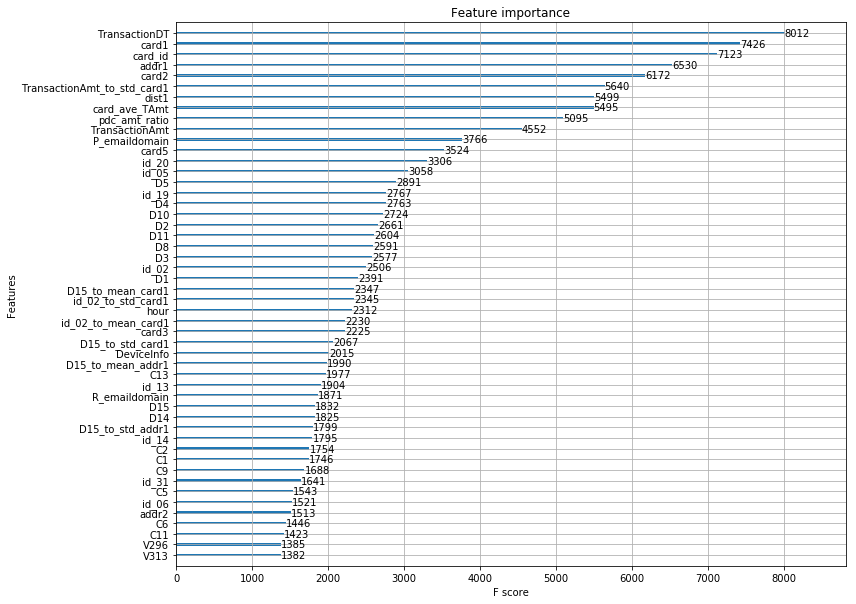

In [22]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(model, max_num_features=50,ax=ax)

# Train Model

In [27]:
splits = 5
folds = KFold(n_splits = splits,random_state=RSEED)
predictions = np.zeros(len(features_test_new))
ave_auc = 0

In [28]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    train_set = xgb.DMatrix(train_df, label=y_train_df)
    valid_set = xgb.DMatrix(valid_df, label=y_valid_df)
    test_set = xgb.DMatrix(features_test_new)
    watchlist = [(train_set, 'train'), (valid_set, 'valid')]
    
    valid_results = {}
    clf = xgb.train(params,train_set,num_boost_round = 10000, 
                    evals = watchlist,
                    verbose_eval=500,
                    early_stopping_rounds = 500,
                    evals_result=valid_results)
    
    
    pred = clf.predict(valid_set)
    auc_score = roc_auc_score(y_valid_df, pred)
    ave_auc += auc_score / splits
    predictions += clf.predict(test_set) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.92931	valid-auc:0.786636
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[500]	train-auc:1	valid-auc:0.912303
Stopping. Best iteration:
[158]	train-auc:1	valid-auc:0.916262

Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.929245	valid-auc:0.821946
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[500]	train-auc:1	valid-auc:0.924795
Stopping. Best iteration:
[113]	train-auc:0.999998	valid-auc:0.927277

Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.931893	valid-auc:0.822766
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[500]	train-auc:1	valid-auc:0.926979
Stopping. Best iteration:
[191]	train-auc:1	valid-auc:0.928015

Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.924899	valid-auc:0.834397
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[500]	train-auc:1	valid-auc:0.940966
Stopping. Best iteration:
[107]	train-auc:0.999995	valid-auc:0.94419

Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.929495	valid-auc:0.817949
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[500]	train-auc:1	valid-auc:0.920922
Stopping. Best iteration:
[154]	train-auc:1	valid-auc:0.923878



In [29]:
## learning rate 0.1
ave_auc

0.9245731369649

In [24]:
# learning rate 0.3
ave_auc

0.9159448

In [32]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_xgb_feat%s_lr01.csv'%(feat_num), index = False)